In [2]:
pip install xgboost imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   - -------------------------------------- 3.9/150.0 MB 13.1 MB/s eta 0:00:12
   -- ------------------------------------- 8.1/150.0 MB 15.7 MB/s eta 0:00:10
   --- ------------------------------------ 12.6/150.0 MB 17.1 MB/s eta 0:00:09
   ---- ----------------------------------- 17.6/150.0 MB 18.8 MB/s eta 0:00:08
   ----- ---------------------------------- 21.2/150.0 MB 18.6 MB/s eta 0:00:07
   ------- -------------------------------- 26.7/150.0 MB 19.7 MB/s eta 0:00:07
   -------- ------------------------------- 30.9/150.0 MB 19.6 MB/s eta 0:00:07
   --------- ------------------------------ 35.1/150.0 MB 19.7 MB/s eta 0:00:06
   ---------- ----------------------------- 38.5/150.0 MB 19.3 MB/s eta 0:00:06
   ----------- ---------------------------- 41.4/150.0 MB 19.5

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
sns.set_palette('viridis')

In [4]:
df = pd.read_csv(r"C:\EXCEL_FILES\PS_20174392719_1491204439457_log.csv")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
print("Dataset Information:")
df.info()

print("\nSummary Statistics:")
print(df.describe().T)

missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Summary Statistics:
                    count          mean           std  min       25%  \
step            6362620.0  2.433972e+02  1.423320e+02  1.0    156.00   
amount          6362620.0  1.798619e+05  6.038582e+05  0.0  13389.57   
oldbalanceOrg   6362620.0  8.338831e+05  2.888243e+06  0.0      0.00   
newbalanceOrig  6362620.0  8.551137e+05  2.924049e+06  0.0      0.00   
oldbalanceDest  6362620.0  1.100702e+06  3.3

Distribution of transactions:
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


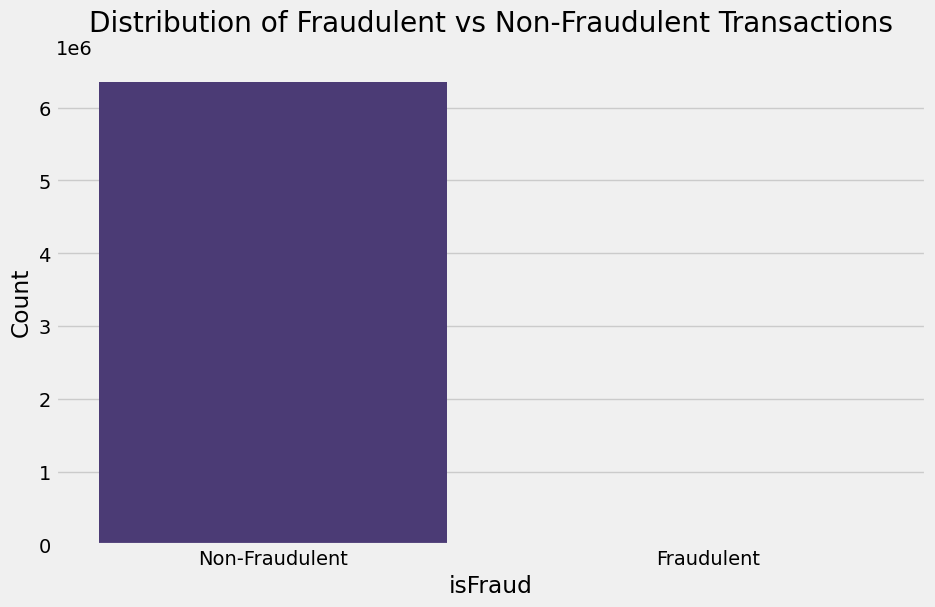

In [7]:
fraud_distribution = df['isFraud'].value_counts(normalize=True) * 100
print("Distribution of transactions:")
print(fraud_distribution)

plt.figure(figsize=(10, 6))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.ylabel('Count')
plt.show()

Transaction Types:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


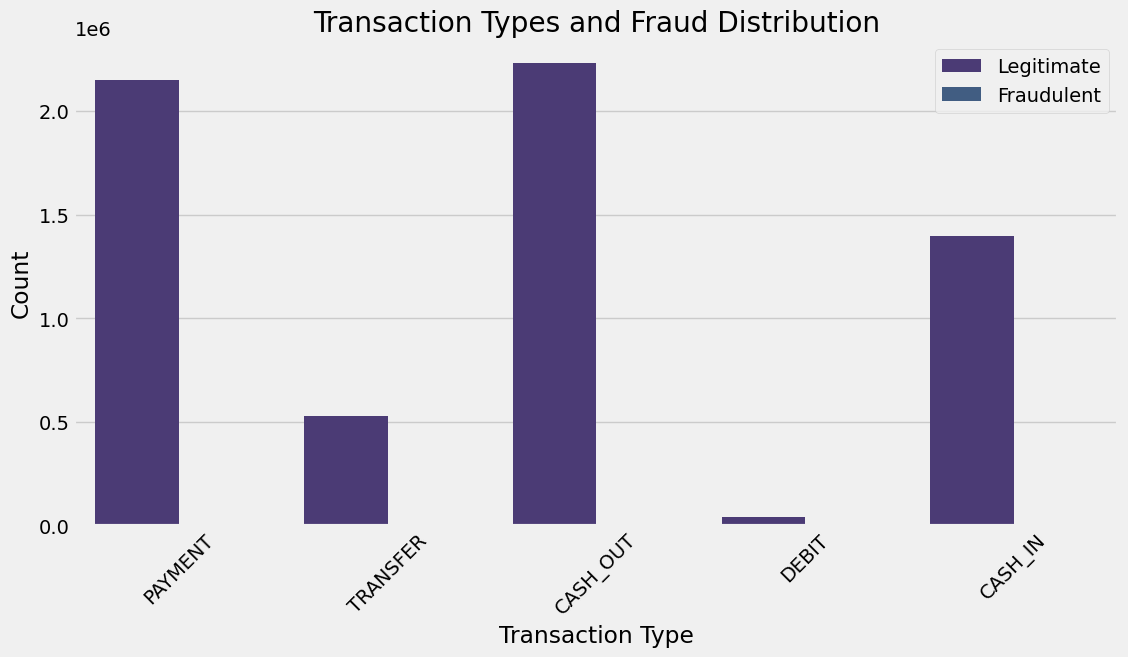

Fraud Rate by Transaction Type (%):
 type
CASH_IN     0.000000
CASH_OUT    0.183955
DEBIT       0.000000
PAYMENT     0.000000
TRANSFER    0.768799
Name: isFraud, dtype: float64


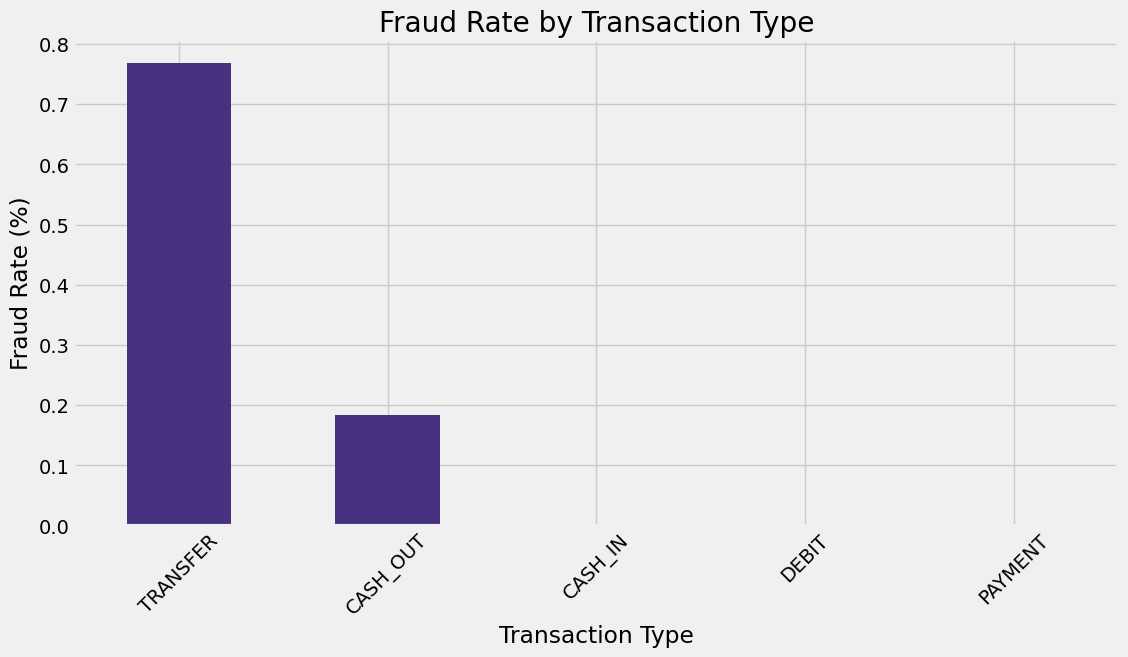

In [34]:
transaction_types = df['type'].value_counts()
print("Transaction Types:")
print(transaction_types)

plt.figure(figsize=(12, 6))
sns.countplot(x='type', data=df, hue='isFraud')
plt.title('Transaction Types and Fraud Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(['Legitimate', 'Fraudulent'])
plt.show()

fraud_by_type = df.groupby('type')['isFraud'].mean() * 100
print("Fraud Rate by Transaction Type (%):\n", fraud_by_type)

plt.figure(figsize=(12, 6))
fraud_by_type.sort_values(ascending=False).plot(kind='bar')
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=45)
plt.show()

In [35]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['type'], df['isFraud'])
print("Contingency Table:")
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square value: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Statistically significant association: {p < 0.05}")

Contingency Table:
isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097

Chi-square value: 22082.53571319108
p-value: 0.0
Degrees of freedom: 4
Statistically significant association: True


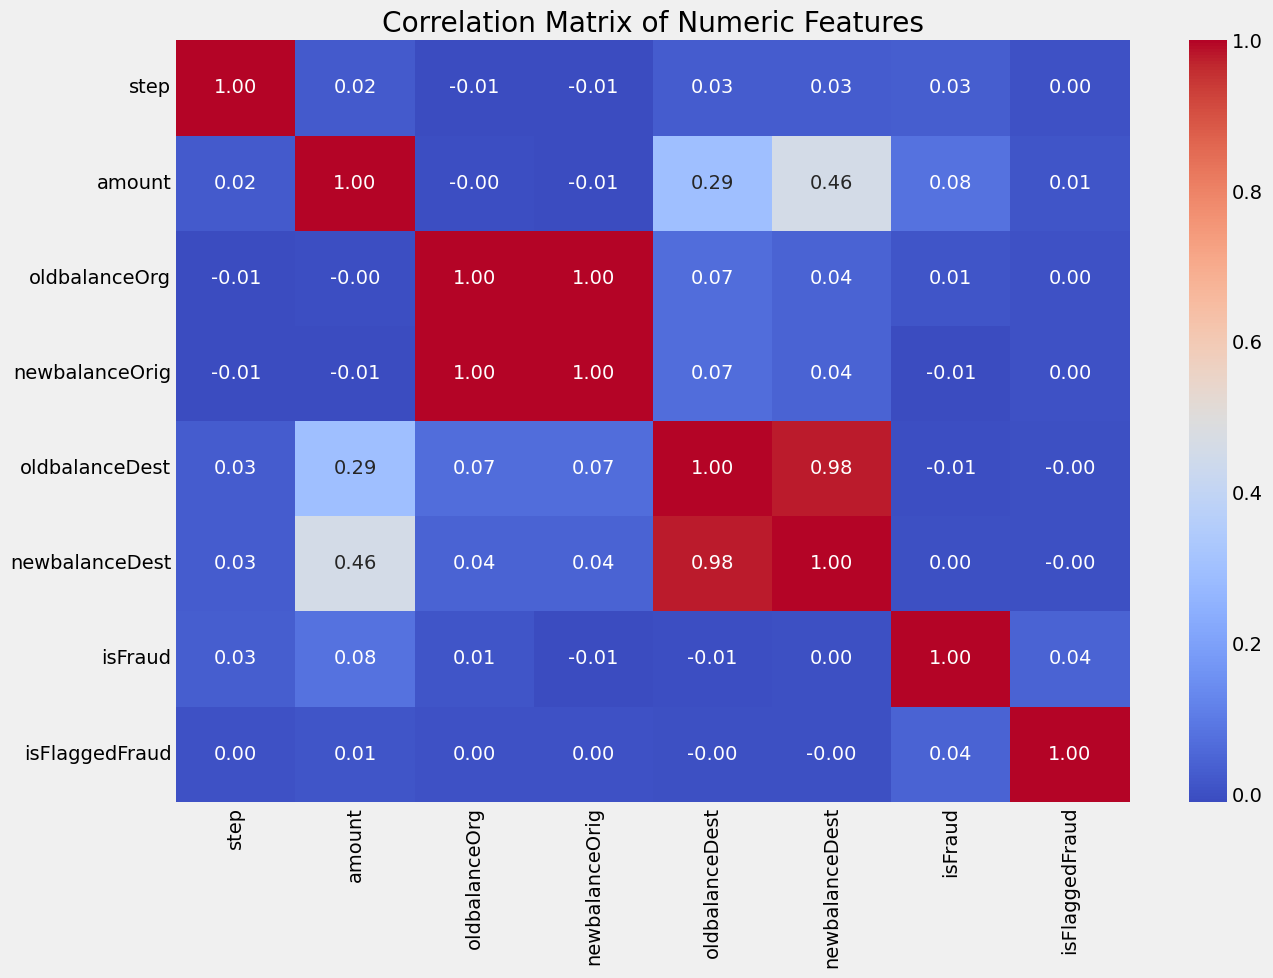

In [12]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(14, 10))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

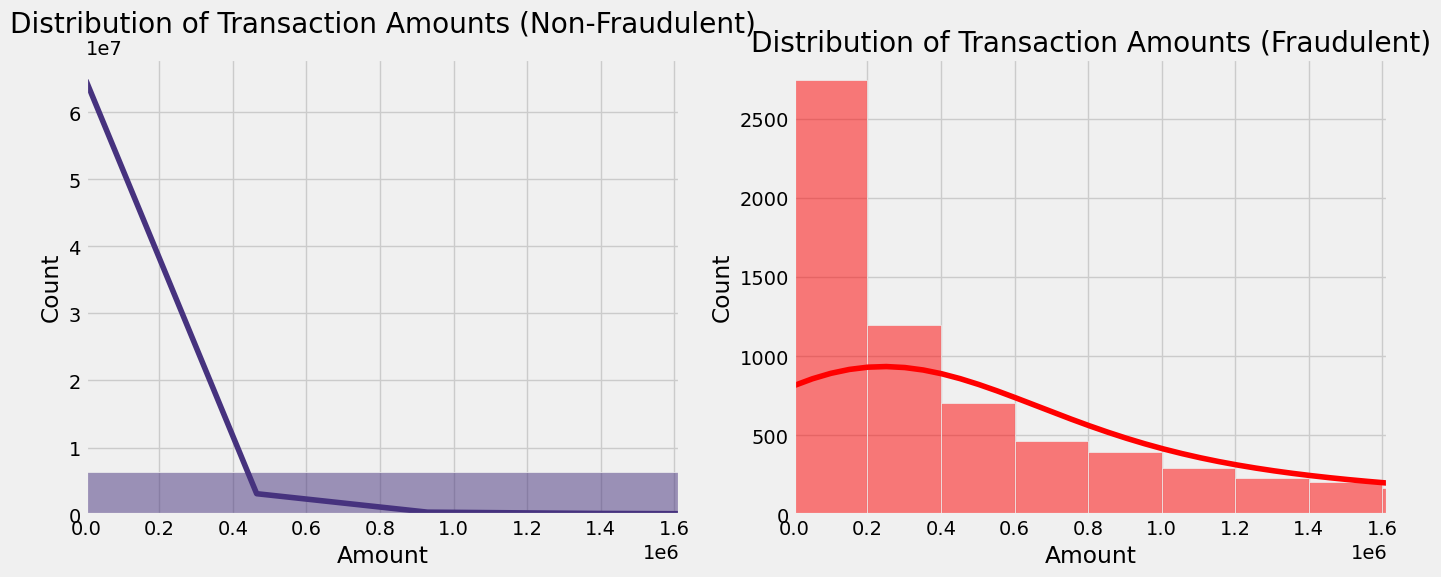

Amount Statistics by Fraud Status:
                 mean     median   min          max           std
isFraud                                                          
0        1.781970e+05   74684.72  0.01  92445516.64  5.962370e+05
1        1.467967e+06  441423.44  0.00  10000000.00  2.404253e+06


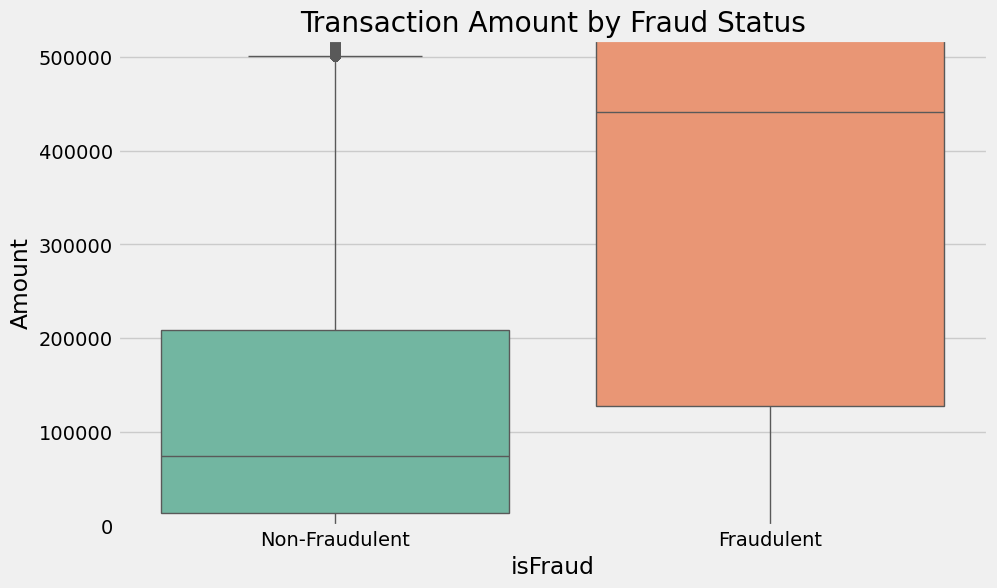

In [36]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['isFraud'] == 0]['amount'], kde=True, bins=50)
plt.title('Distribution of Transaction Amounts (Non-Fraudulent)')
plt.xlabel('Amount')
plt.xlim([0, df['amount'].quantile(0.99)]) 
plt.subplot(1, 2, 2)
sns.histplot(df[df['isFraud'] == 1]['amount'], kde=True, bins=50, color='red')
plt.title('Distribution of Transaction Amounts (Fraudulent)')
plt.xlabel('Amount')
plt.xlim([0, df['amount'].quantile(0.99)]) 

plt.tight_layout()
plt.show()

amount_stats = df.groupby('isFraud')['amount'].agg(['mean', 'median', 'min', 'max', 'std'])
print("Amount Statistics by Fraud Status:")
print(amount_stats)

plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df, palette='Set2')
plt.title('Transaction Amount by Fraud Status')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.ylabel('Amount')
plt.ylim([0, df['amount'].quantile(0.95)]) 
plt.show()

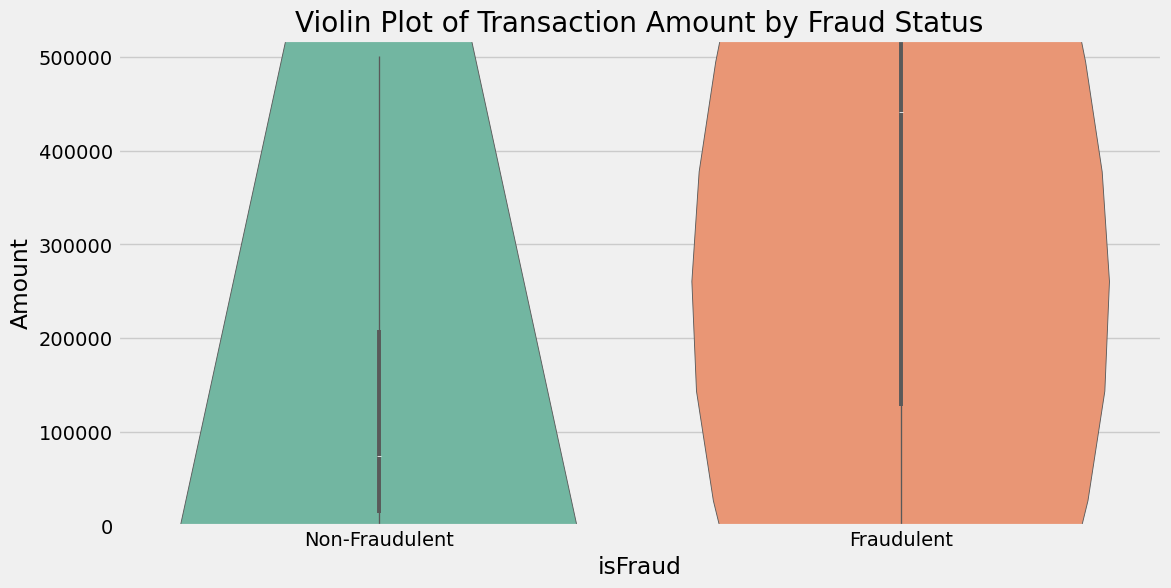

Mann-Whitney U Test (comparing transaction amounts):
U statistic: 41224999611.0
p-value: 0.0
Statistically significant difference: True


In [37]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='isFraud', y='amount', data=df, palette='Set2')
plt.title('Violin Plot of Transaction Amount by Fraud Status')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.ylabel('Amount')
plt.ylim([0, df['amount'].quantile(0.95)])
plt.show()

from scipy.stats import mannwhitneyu

fraud_amounts = df[df['isFraud'] == 1]['amount']
non_fraud_amounts = df[df['isFraud'] == 0]['amount']

u_stat, p_value = mannwhitneyu(fraud_amounts, non_fraud_amounts)

print("Mann-Whitney U Test (comparing transaction amounts):")
print(f"U statistic: {u_stat}")
print(f"p-value: {p_value}")
print(f"Statistically significant difference: {p_value < 0.05}")

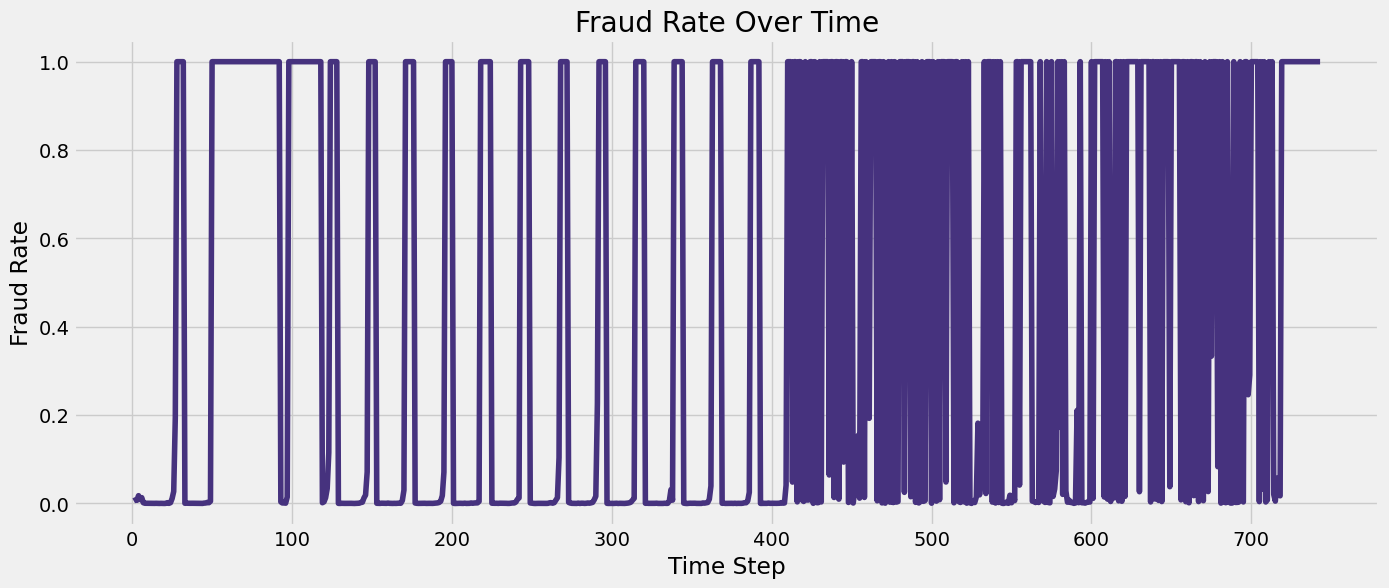

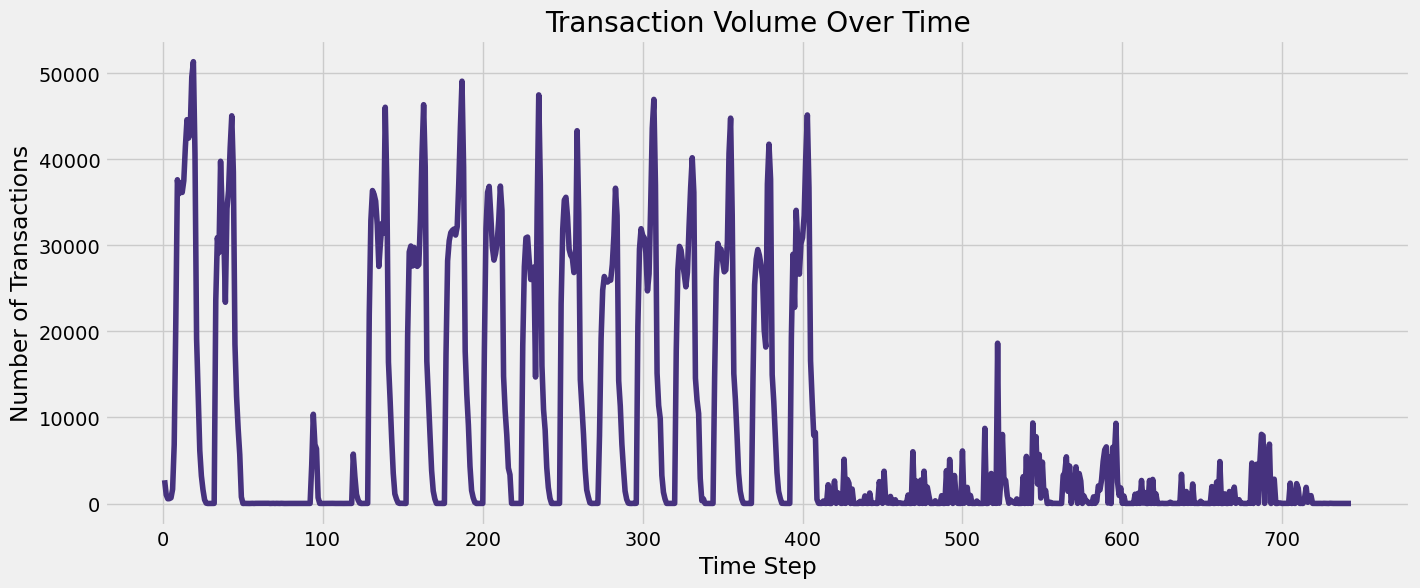

In [38]:
if 'step' in df.columns:
    plt.figure(figsize=(15, 6))
    fraud_over_time = df.groupby('step')['isFraud'].mean()
    fraud_over_time.plot()
    plt.title('Fraud Rate Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Fraud Rate')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(15, 6))
    df.groupby('step').size().plot()
    plt.title('Transaction Volume Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Transactions')
    plt.grid(True)
    plt.show()

In [39]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

sample_size = 100000
if len(df) > sample_size:
    df = df.sample(n=sample_size, random_state=42)
    print(f"Sampled dataset to {len(df)} rows")

df_encoded = df.copy()
for col in categorical_cols:
    if df[col].nunique() > 50: 
        encoding_map = df.groupby(col)['isFraud'].mean().to_dict()
        df_encoded[col + '_encoded'] = df_encoded[col].map(encoding_map)
        df_encoded.drop(col, axis=1, inplace=True)
        print(f"Target encoded {col} with {df[col].nunique()} categories")
    else:
        pass

remaining_cat_cols = [col for col in categorical_cols if col in df_encoded.columns]
if remaining_cat_cols:
    print(f"One-hot encoding {len(remaining_cat_cols)} columns with low cardinality")
    df_encoded = pd.get_dummies(df_encoded, columns=remaining_cat_cols, drop_first=True)

X = df_encoded.drop('isFraud', axis=1)
y = df_encoded['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Categorical columns:
type: 5 unique values
nameOrig: 6353307 unique values
nameDest: 2722362 unique values
Sampled dataset to 100000 rows
Target encoded nameOrig with 99999 categories
Target encoded nameDest with 92914 categories
One-hot encoding 1 columns with low cardinality
Training set shape: (70000, 13)
Testing set shape: (30000, 13)


In [40]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set shape: {X_train_scaled.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Original class distribution: {pd.Series(y_train).value_counts(normalize=True) * 100}")
print(f"Resampled class distribution: {pd.Series(y_train_resampled).value_counts(normalize=True) * 100}")

Original training set shape: (70000, 13)
Resampled training set shape: (139802, 13)
Original class distribution: isFraud
0    99.858571
1     0.141429
Name: proportion, dtype: float64
Resampled class distribution: isFraud
0    50.0
1    50.0
Name: proportion, dtype: float64


In [8]:
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

In [9]:
X = pd.get_dummies(X, columns=['type'], drop_first=True)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

In [ ]:
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=50,
    random_state=42
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

Random Forest Model Performance:

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29958
           1       1.00      1.00      1.00        42

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



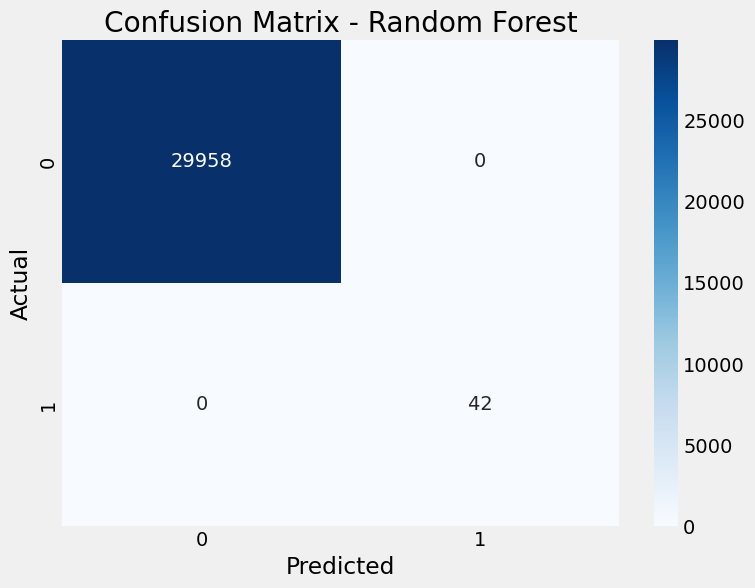

In [41]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Random Forest Model Performance:\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

XGBoost Model Performance:

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29958
           1       1.00      1.00      1.00        42

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



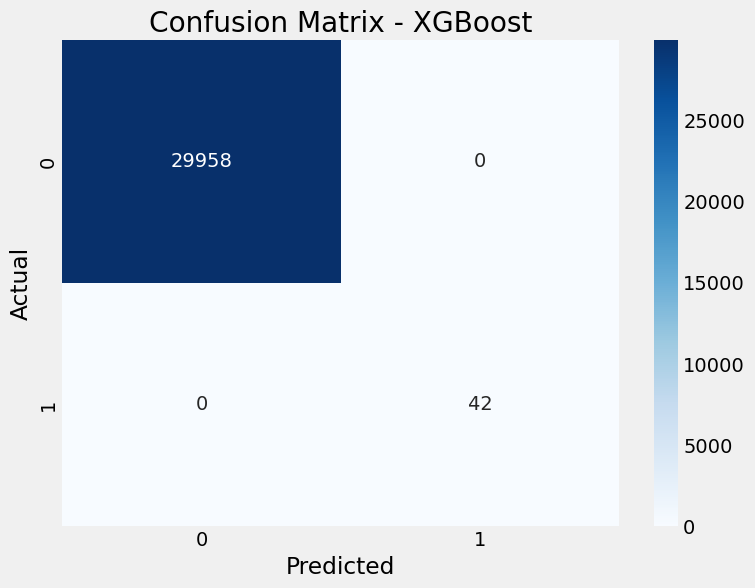

In [42]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("XGBoost Model Performance:\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

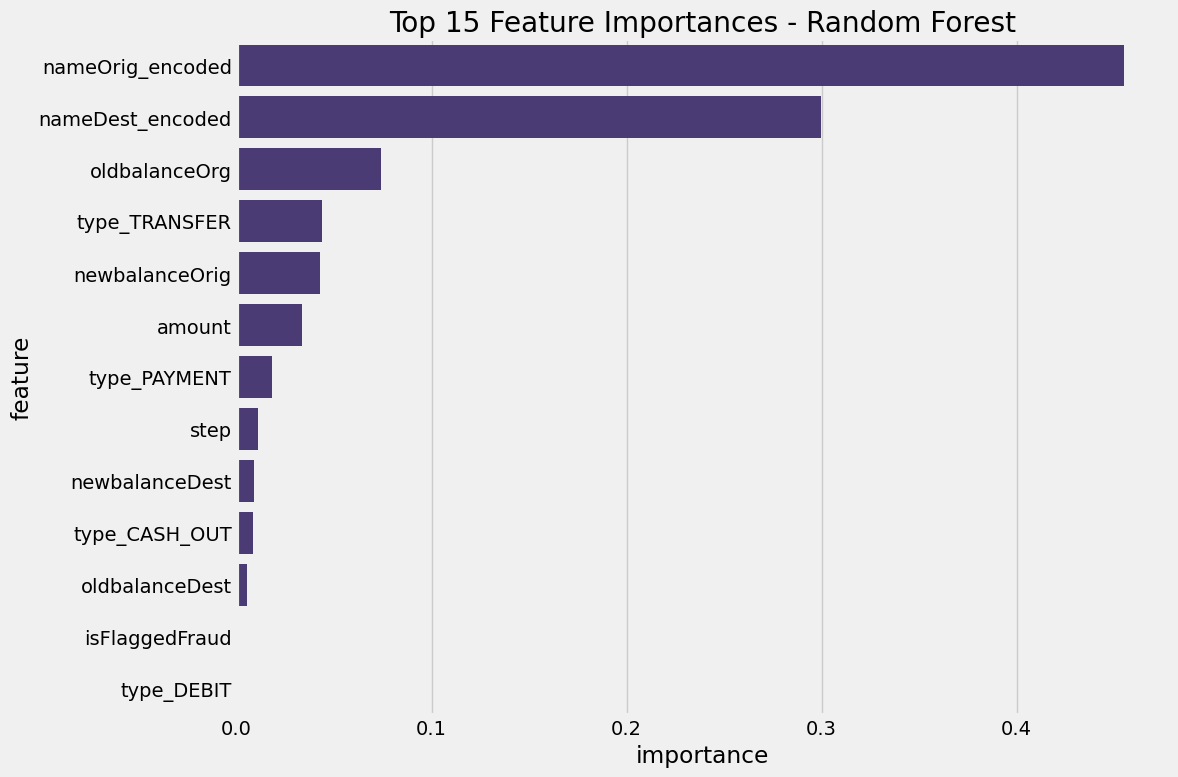

In [43]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

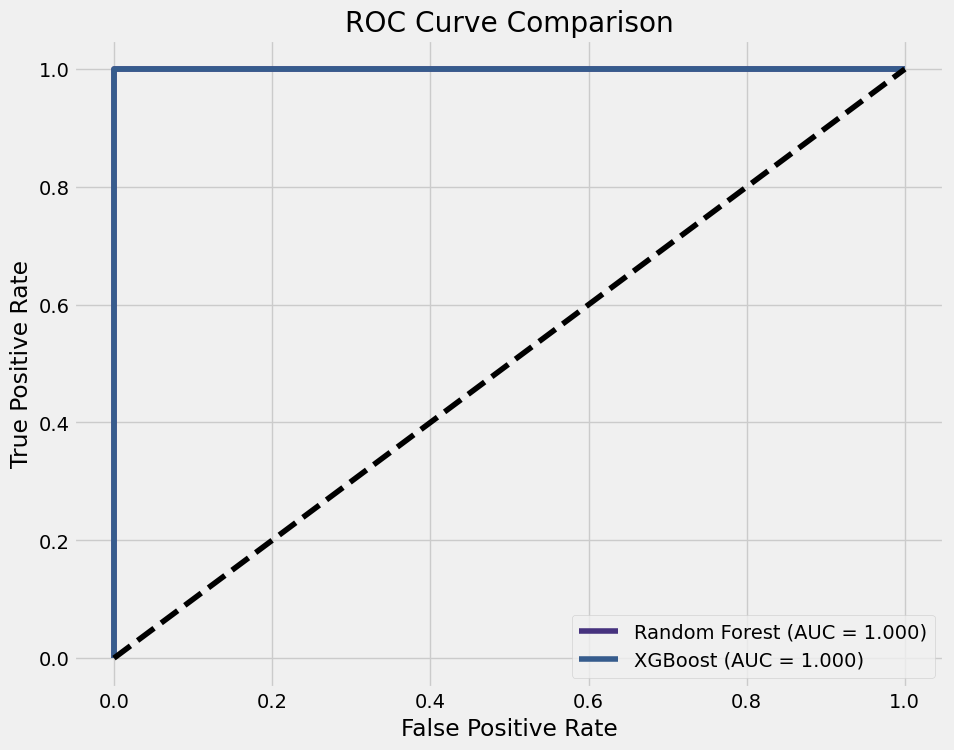

In [44]:
plt.figure(figsize=(10, 8))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

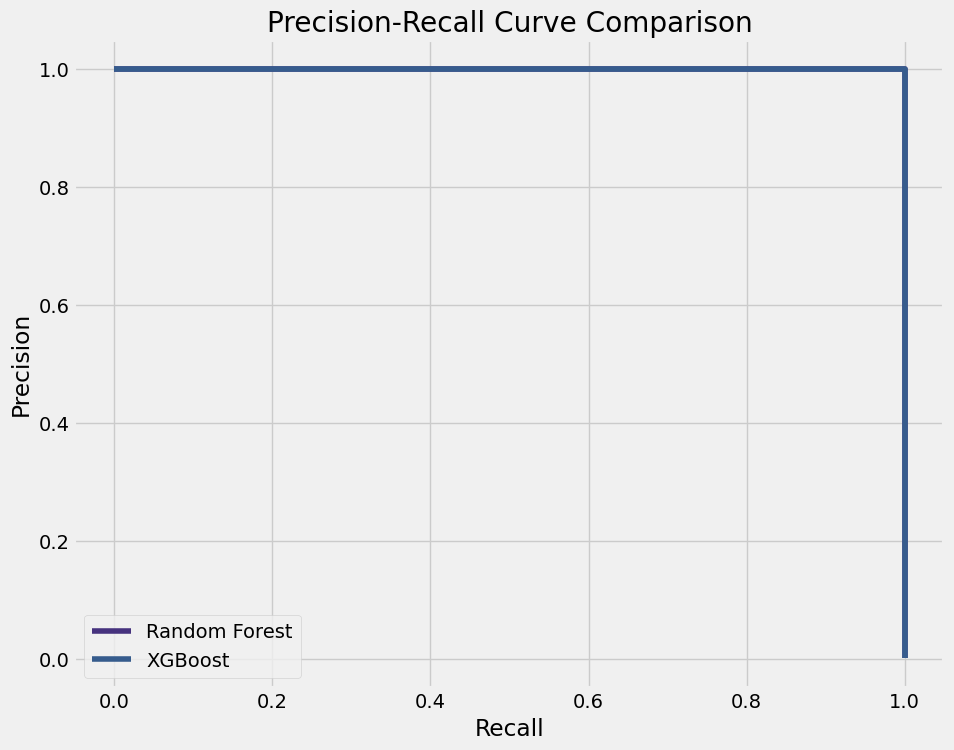

In [45]:
plt.figure(figsize=(10, 8))

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
plt.plot(recall_rf, precision_rf, label=f'Random Forest')

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.grid(True)
plt.show()